### 0. Library and Datasets

In [ ]:
! pip install scikit-learn
! pip install tensorflow
! pip install keras

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score,
                             roc_auc_score, confusion_matrix)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Embedding, Conv1D,
                                     GlobalMaxPooling1D, Dense)

In [23]:
df_original = pd.read_csv("/content/combined_data.csv", lineterminator='\n')

### 1. Cleaning

In [55]:
df = pd.DataFrame(df_original)
df['text'] = df['sender'] + ' ' + df['receiver'] + ' ' + df['date'] + ' ' + df['subject'] + ' ' + df['body']
df = df[['text', 'label']]

In [56]:
# Prepare the text and labels
X = df['text'].values
y = df['label'].values

# Tokenization
maximum_features = 5000  # Maximum number of words to consider as features
maximum_length = 100  # Maximum length of input sequences

tokenizer = Tokenizer(num_words=maximum_features)
tokenizer.fit_on_texts(X)  # Fit the tokenizer on the text data

# Convert texts to sequences of integers
X_sequences = tokenizer.texts_to_sequences(X)

# Padding the sequences to ensure uniform length
x_train = pad_sequences(X_sequences, maxlen=maximum_length)

### 2. EDA

In [57]:
print(df.info())

print(df.head())

print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171961 entries, 0 to 171960
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    171961 non-null  object
 1   label   171961 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.6+ MB
None
                                                text  label
0  "Hu, Sylvia" <Sylvia.Hu@ENRON.com> "Acevedo, F...      0
1  "Webb, Jay" <Jay.Webb@ENRON.com> "Lambie, Chri...      0
2  "Symms, Mark" <Mark.Symms@ENRON.com> "Thomas, ...      0
3  "Thorne, Judy" <Judy.Thorne@ENRON.com> "Grass,...      0
4  "Williams, Jason R (Credit)" <Jason.R.Williams...      0
label
0    91321
1    80640
Name: count, dtype: int64


### 3. Train-Test Split

In [58]:
# Split data into training and testing sets (you can adjust the split ratio)
split_ratio = 0.8
split_index = int(len(x_train) * split_ratio)

x_train_data = x_train[:split_index]
y_train_data = y[:split_index]
x_test_data = x_train[split_index:]
y_test_data = y[split_index:]

# Display the shapes of the resulting datasets
print(f"Training data shape: {x_train_data.shape}, Training labels shape: {y_train_data.shape}")
print(f"Testing data shape: {x_test_data.shape}, Testing labels shape: {y_test_data.shape}")

Training data shape: (137568, 100), Training labels shape: (137568,)
Testing data shape: (34393, 100), Testing labels shape: (34393,)


### 4. Model Testing: CNN

In [67]:
# Setting up the model parameters
word_embedding_dims = 128  # Increased dimension of word embeddings for better representation
no_of_filters = 512  # Increased number of filters in the convolutional layer for richer feature extraction
kernel_size = 5  # Slightly larger kernel size to capture more context in the text
hidden_dims = 512  # Increased number of neurons in the hidden layer for enhanced capacity
batch_size = 64  # Larger batch size to speed up training and better use of hardware resources
epochs = 10  # Increased number of training epochs to allow the model to learn more from the data
threshold = 0.5  # Threshold for binary classification, can be adjusted based on ROC curve analysis

In [68]:
# Building the model
model = Sequential()

# Adding the embedding layer to convert input sequences to dense vectors
model.add(Embedding(maximum_features, word_embedding_dims))

# Adding the 1D convolutional layer with ReLU activation
model.add(Conv1D(no_of_filters, kernel_size, padding='valid',
                 activation='relu', strides=1))

# Adding the global max pooling layer to reduce dimensionality
model.add(GlobalMaxPooling1D())

# Adding the dense hidden layer with ReLU activation
model.add(Dense(hidden_dims, activation='relu'))

# Adding the output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

In [69]:
# Compiling the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

# Training the model
model.fit(x_train_data, y_train_data, batch_size=batch_size,
          epochs=epochs, validation_data=(x_test_data, y_test_data))

# Predicting the probabilities for test data
y_pred_prob = model.predict(x_test_data)

# Converting the probabilities to binary classes based on threshold
y_pred = (y_pred_prob > threshold).astype(int)

Epoch 1/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9421 - loss: 0.1306 - val_accuracy: 0.9426 - val_loss: 0.3647
Epoch 2/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9914 - loss: 0.0255 - val_accuracy: 0.9470 - val_loss: 0.5267
Epoch 3/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9959 - loss: 0.0131 - val_accuracy: 0.9395 - val_loss: 0.4874
Epoch 4/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9977 - loss: 0.0077 - val_accuracy: 0.9371 - val_loss: 0.6306
Epoch 5/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9983 - loss: 0.0051 - val_accuracy: 0.9409 - val_loss: 0.8363
Epoch 6/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9985 - loss: 0.0043 - val_accuracy: 0.9438 - val_loss: 1.0045
Epoch 7/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9988 - loss: 0.0036 - val_accuracy: 0.9455 - val_loss: 0.6452
Epoch 8/10
2150/2150 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9989 - loss: 0

Accuracy: 0.9443491408135376
Precision: 0.974632768361582
Recall: 0.9217247275058773
F1-score: 0.9474406854130053
ROC AUC: 0.9658101820897266


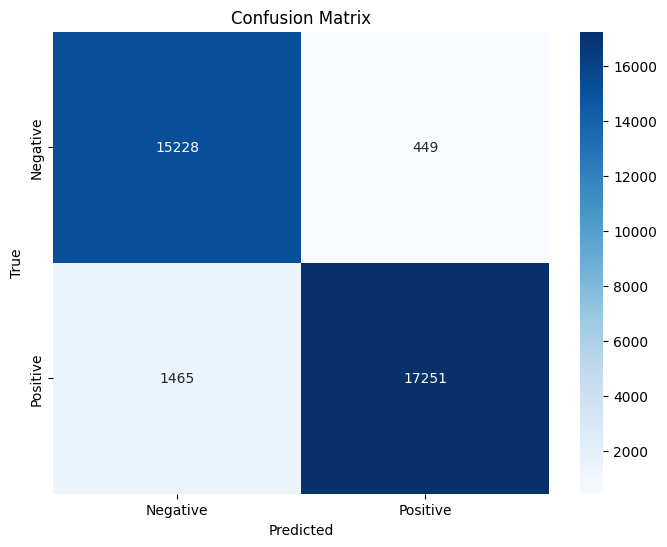

In [70]:
# Calculating the evaluation metrics
accuracy = accuracy_score(y_test_data, y_pred)
precision = precision_score(y_test_data, y_pred)
recall = recall_score(y_test_data, y_pred)
f1 = f1_score(y_test_data, y_pred)
roc_auc = roc_auc_score(y_test_data, y_pred_prob)  # Calculate ROC AUC

# Printing the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print('ROC AUC:', roc_auc)  # Print ROC AUC score

# Confusion Matrix
cm = confusion_matrix(y_test_data, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()